In [1]:
# import libraries
import numpy as np
import pandas as pd

# seaborn is for making plots
import seaborn as sns
import matplotlib.pyplot as plt
import regex
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# These are all the imports needed for the assignment
%matplotlib inline

#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

## Linear Regression

In [2]:
columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']

- "C:/Users/19495/Downloads/amazon_reviews_us_Toys_v1_00.tsv.gz"

- names = columns because this allows is to focus on only the attributes we care about

- sep = '\t' since this is a tsv file, this informs program to separate based on tabs, not commas

- check that on_bad_lines arg is not removing valid things!

- **take out first line! because there is a restatement of the column names so string**

In [3]:
# initializing empty dataframes for testing and training data
training_data = pd.DataFrame()
testing_data = pd.DataFrame()
# on_bad_lines = 'skip' does not seem to work
one_file = pd.read_csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", names =  columns, sep = '\t').iloc[1:,:]

In [4]:
one_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
2,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
3,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
4,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
5,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [5]:
one_file.shape

(3091103, 15)

In [6]:
one_file.isnull().sum().sort_values(ascending = False)

review_body          88
review_headline      31
review_date          24
product_title         4
verified_purchase     0
vine                  0
total_votes           0
helpful_votes         0
star_rating           0
product_category      0
product_parent        0
product_id            0
review_id             0
customer_id           0
marketplace           0
dtype: int64

In [7]:
one_file.dropna(inplace=True)
one_file.isnull().sum().sort_values(ascending = False)

review_date          0
review_body          0
review_headline      0
verified_purchase    0
vine                 0
total_votes          0
helpful_votes        0
star_rating          0
product_category     0
product_title        0
product_parent       0
product_id           0
review_id            0
customer_id          0
marketplace          0
dtype: int64

In [8]:
#convert all mixed datatypes --> string objects (unable to convert to int)
one_file['customer_id'] = one_file['customer_id'].apply(int) #1
one_file['product_parent'] = one_file['product_parent'].apply(int) #4
one_file['star_rating'] = one_file['star_rating'].apply(int) #7
one_file['helpful_votes'] = one_file['helpful_votes'].apply(int) #8
one_file['total_votes'] = one_file['total_votes'].apply(int) #9

In [9]:
one_file['star_rating'].value_counts()

5    1779347
4     536400
1     357802
3     238382
2     179025
Name: star_rating, dtype: int64

General Notes
- to remove certain column values, run smthg like one_file[one_file["star_rating"] != 3]

In [10]:
# df w/ ratings of 3 removed for sentiment analysis
rem_file = one_file[one_file['star_rating'] != 3]
# if rating greater than 3 --> 1, if lower --> 0
rem_file['positively_rated'] = np.where(rem_file['star_rating'] > 3, 1, 0)

In [11]:
rem_file['positively_rated'].value_counts()

1    2315747
0     536827
Name: positively_rated, dtype: int64

In [12]:
rem_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,positively_rated
1,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31,1
2,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31,1
3,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31,1
4,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31,0
5,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31,1


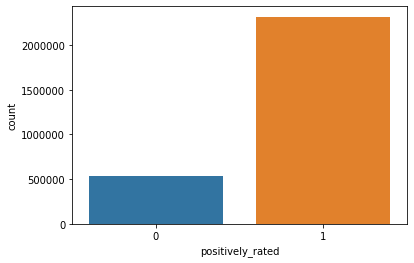

In [13]:
sns.countplot(rem_file['positively_rated'])

- 'review_body' is the independent variable, while 'positively_rated' is the dependent variable

In [14]:
x_train, x_test, y_train, y_test = train_test_split(rem_file['review_body'], rem_file['positively_rated'], 
                                                    random_state = 50)

In [15]:
print(x_train)

1539775    Flimsy construction and poor sound range vs so...
2504431    Product did not work. I hooked up both ends. O...
3070343    I purchased both the ZHDTV and the ...RCA ampl...
1250047    UPDATE!!!<br />The team at Mpow really stand b...
1905213    No complaints; these are perfect!  I wish they...
                                 ...                        
2747483    This may be the most rugged CD/DVD storage pos...
729500     It works great. I was having problems getting ...
2526170    This shelving unit was easy to put together an...
1241297                       Great product at a great price
2139970    Searched the net for several weeks before deci...
Name: review_body, Length: 2139430, dtype: object


- the .get_feature_names() will give us the # of diff terms! Features w/ low tf-idf scores are either very common across all reviews or rarely used. High tf-idf features are highly used in specific reviews, but rarely used in all docs

In [16]:
vect = TfidfVectorizer().fit(x_train)
len(vect.get_feature_names())

308301

In [17]:
x_train_vectorized = vect.transform(x_train)

In [18]:
# This is model fitting. Once it's done, we can make predictions
model = LogisticRegression()
model.fit(x_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
predictions = model.predict(vect.transform(x_test))
print(predictions)

[1 0 1 ... 1 1 1]


In [20]:
# Compute AUC score
print("AUC:", roc_auc_score(y_test, predictions))

AUC: 0.8844488688126042


In [21]:
# Look at which sentiments have the smallest and largest tf-idf score
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

- The Smallest Coef words either appear across all reviews, or only really in long reviews
- The Largest Coef words appear frequently in a review but did not appear commonly across all reviews

In [22]:
print("Smallest Coef", feature_names[sorted_coef_index[:10]])

Smallest Coef ['not' 'unacceptable' 'poor' 'worst' 'useless' 'returning' 'terrible'
 'disappointing' 'worthless' 'stopped']


In [23]:
print("Largest Coef", feature_names[sorted_coef_index[:-11:-1]])

Largest Coef ['great' 'love' 'perfect' 'excellent' 'perfectly' 'amazing' 'awesome'
 'highly' 'best' 'easy']


## Experimentation
- Try fiddling with, and cleaning the different features if possible
- Try removing one word reviews, and see the difference in accuracy (try on Suki's KNN)

In [39]:
# verified_purchase, star_rating, helpful_votes, total_votes, rev_title_comp, neg_prop, neu_prop, pos_prop
# Accuracy went down with addition of compound prop, maybe overfitting?
# prod_title_comp
# Run sentiment analysis
# marketplace --> using alphabet to convert to numbers
# helpful votes proportion --> get rid of total_votes

In [40]:
# try removing one word reviews and see the diff
# try it on suki's knn

## Data Sampling

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [21]:
columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', \
           'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']
elec_df = pd.read_csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", names =  columns, sep = '\t').iloc[1:,:]

In [30]:
#try_df = elec_df[elec_df['customer_id'] == 2462611]
try_df = elec_df.iloc[[2462611]]
try_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2462612,US,12340766,R2RYU79O2TFNO1,B0038W0K2K,952833522,MEElectronics Sport-Fi M6 Noise Isolating In-Ear Headphones with Memory Wire,Electronics,3,0,0,N,Y,need better wrap arounds for ears,the sound is excellent however the wrap around the ear is not the best. If exercising i had to adjust the ear pieces a few times.,2012-01-05


In [5]:
elec_df = elec_df[: 200_000]
elec_df.shape

(200000, 15)

In [6]:
def df_sampling(df):
    # Since we know that there are more unverified than verified --> we sample based on that
    
    # Since there are no data values in 'verified_purchase' columns that deviate from 'Y' or 'N' we proceed
    verified_count_df = df[df['verified_purchase'] == 'Y']
    unverified_count_df = df[df['verified_purchase'] == 'N']
    
    print("Number of verified purchases:", len(verified_count_df))
    print("Number of unverified purchases:", len(unverified_count_df))
    
    sample_len = len(unverified_count_df)
    
    verified_sample_df = verified_count_df.sample(n = sample_len)
    unified_df = pd.concat([unverified_count_df, verified_sample_df])
    
    print("Number of verified purchases (balanced dataset):", len(unified_df[unified_df['verified_purchase'] == 'Y']))
    print("Number of unverified purchases (balanced dataset):", len(unified_df[unified_df['verified_purchase'] == 'N']))
    
    return unified_df

In [7]:
balanced_elec = df_sampling(elec_df)
display(balanced_elec.head())

Number of verified purchases: 183808
Number of unverified purchases: 16192
Number of verified purchases (balanced dataset): 16192
Number of unverified purchases (balanced dataset): 16192


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
21,US,42944532,R1OD3VMIZCCADZ,B012VIWG28,676077256,Brainwavz Hengja - The Headphone Desk Hanger,Electronics,5,0,0,N,N,"Simple hanger; clamp is strong, with a pad; hanger swivels to accommodate many possible attachment locations","Can't get any simpler that this. And it works just about anywhere you can find a flat lip or side panel. Ideally the lip should be at least 1 3/8&#34; for best stability, but I got it to hold decently well on the short lip of my desk top, which is just 3/4&#34;.<br /><br />Because the front hanger piece can be adjusted to hang parallel or perpendicular, (or any angle in between), to the clamping surface, I was able to get the firmest grip on the side of a bookcase. My best idea, and where I use it now, is attached to the arm of my executive style office chair, near where it meets the chair back. I don't knock it with my arm or elbow as I raise/lower/turn in my chair. It is really a nifty place to stow the headphones--within easy reach, but not a cumbersome location either.<br /><br />It is well-constructed with good layer of powder coating on the metal. Hardware looks to be top quality, too.<br /><br />*I received a sample product from Brainwavz.",2015-08-31
52,US,143935,R3GWX8AYXWO5ZE,B00GHQMZ7W,318981354,Brookstone - SoundShield Noise Cancelling Stereo Headphones,Electronics,4,0,0,N,N,... and being an active traveler they have held up pretty well. Comfortable for long flights and still have ...,Bought these a year ago and being an active traveler they have held up pretty well. Comfortable for long flights and still have 100% noise cancellation,2015-08-31
56,US,11990894,R2MXU8IVR1Q1S5,B00SQ94K7Q,783049725,"SOUNDXL Blackout C-Series Bluetooth Wireless Waterproof Speaker for iPhones, Android, Tablets, Smartphones and MP3 Speaker",Electronics,5,1,1,N,N,Perfect gift for everyone on your list or treat yourself! Great quality!,Enjoy crystal clear clarity sound with this product! Super great quality! Highly recommended! Would make a perfect gift for anyone or for yourself!!,2015-08-31
58,US,7063270,R3QLZUL02LTP06,B00MRUX9IG,684454145,"Comply Foam Premium Earphone Tips - Isolation T-100 (Multi-Color, 3-Pairs, Large)",Electronics,2,0,0,N,N,Happy For about 4 weeks using these in the gym,Happy For about 4 weeks using these in the gym. The tips then lost the sponginess and then teared over time. I kept my headphones in a case and yet they wear out when you use them after a few weeks.,2015-08-31
62,US,33972520,R99E5GE71NOWK,B00XVQ0PCS,220816069,"iDeaUSA Wireless Speaker, Bluetooth 4.0 Bass Speaker, Subwoofer and Boombox Outdoor Speaker, with Mic for Hands Free Calling, NFC Supported for IOS and Android Smartphone and Tablet (Black&Red)",Electronics,5,0,0,N,N,Wonderful for bicycles,Our family loves to go bike riding but i get bored after a while. I got a free trial of these Taco speakers and took them along one time when i rode for a while. Put on my favorite jam and jammed out to the amazing music.,2015-08-31


## Data Cleaning
- Referenced from code in https://monkeylearn.com/blog/text-cleaning/ and https://www.kaggle.com/code/ragnisah/text-data-cleaning-tweets-analysis/notebook

In [8]:
# Import re for text cleaning purposes
import re

import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\19495\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\19495\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def df_cleaning(df):
    # Drop rows with na values
    df.dropna(inplace = True)
    
    df['new_review_body'] = df['review_body'].copy()
    
    # Remove unwanted formatting characters
    format_strs = dict.fromkeys(['<br /><br />', '&#34', 'br', '&quot', '<br />'], ' ')
    for key in format_strs:
        df['new_review_body'] = df['new_review_body'].apply(lambda review: review.replace(key, format_strs[key]))
    # removing quotes produces smthg like this --> 'The product has great ;sound; --> we must remove punctuation

    # Case normalization (lower case)
    df['new_review_body'] = df['new_review_body'].str.lower()
    
    # Removing numbers
    remove_num_dict = {"0": "", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "", "9": "",
                   "(": "", ")":""}
    for key, val in remove_num_dict.items():
        df['new_review_body'] = df['new_review_body'].apply(
            lambda x: x.replace(key, val))
    
    # Remove stopwords
    stop_lst = stopwords.words('english')
    stop_lst += (["can't", "i'm" "i'd", "i've", "i'll", "that's", "there's", "they're"])
    # ****Do we not have to take stopwords out BEFORE removing punctuation? Otherwise words with punct like “cant” remains there
    df['new_review_body'] = df['new_review_body'].apply(lambda text_body: " ".join([word for word in text_body.split() if word not in (stop_lst)]))
    
    # Removing Unicode Chars (punctuation, URL, @)
    df['new_review_body'] = df['new_review_body'].apply(lambda rev: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", rev))
    
    # Lemmatization
    word_lemmatizer = WordNetLemmatizer()
    df['new_review_body'] = df['new_review_body'].apply(lambda txt: " ".join([(word_lemmatizer.lemmatize(word)) for word in txt.split()]))
    
    return df

### Esther's Data Cleaning

In [12]:
# Pre-processing Text Reviews
def data_cleaning(df):
    # Removing emtpy cells
    df.dropna(inplace=True)
    df['review_body_cleaned'] = df['review_body'].copy()
    
    # Removing Unicode Chars (URL)
    df['review_body_cleaned'] = df['review_body_cleaned'].apply(
        lambda rev: re.sub(r"(\w+:\/\/\S+)|^rt|http.+?", "", rev))
        
    # Replace HTML keywords with blank space ("&quot;", "br", "&#34")
    remove_dict = {"<br /><br />": " ", "<br />": " ", "br ": "", "&quot;": " ", "&#34": " ",
                   "<BR>": " ", "_": ""}
    for key, val in remove_dict.items():
        df['review_body_cleaned'] = df['review_body_cleaned'].apply(
            lambda x: x.replace(key, val))
        
    print("\n######## Remove URL and HTML Keywords Complete ########")
    
    # Remove Punctuations and numbers
    tokenizer = RegexpTokenizer(r'\w+')
    df['review_body_cleaned'] = df['review_body_cleaned'].apply(
        lambda x: ' '.join([word for word in tokenizer.tokenize(x)]))
    
    remove_dict = {"0": "", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "", "9": "",
                   "(": "", ")":""}
    for key, val in remove_dict.items():
        df['review_body_cleaned'] = df['review_body_cleaned'].apply(
            lambda x: x.replace(key, val))
    
    print("\n######## Remove Punctuation and Numbers Complete ########")
    
    # Lowercase Words
    df['review_body_cleaned'] = df['review_body_cleaned'].str.lower()
    
    print("\n######## Lowercase Complete ########")

    # Remove Stop Words.
    stop = stopwords.words('english')
      
    df['review_body_cleaned'] = df['review_body_cleaned'].apply(
        lambda x: ' '.join([word for word in x.split() if word.strip() not in stop]))
    
    print("\n######## Remove Stop Words Complete ########")
    
    # Lemmatization using .lemma_
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    df['review_body_cleaned'] = df['review_body_cleaned'].apply(
        lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
    
    print("\n######## Data Cleaning Complete ########")
    
    return df

In [13]:
text = "http://localhost:8891/notebooks/FARS/DataTest%20(3).ipynb"
re.sub(r"(\w+:\/\/\S+)|^rt|http.+?", "", text)
#re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
#@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|

''

- Review 2462611 is overall negative, but getting a positive compound score
- One thing to note is that words like "didnt" are falling through
- Thus tried removing stopwords before removing unicode chars --> if you look to the Sentiment Analysis, the compound score of review 2462611 is actually almost the same. Not much difference, but wondering the overall accuracy
- Maybe also take care of words like LOL or lmao --> How to? These are evaluated as positive

In [32]:
try_df = df_cleaning(try_df)
try_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,new_review_body
2462612,US,12340766,R2RYU79O2TFNO1,B0038W0K2K,952833522,MEElectronics Sport-Fi M6 Noise Isolating In-Ear Headphones with Memory Wire,Electronics,3,0,0,N,Y,need better wrap arounds for ears,the sound is excellent however the wrap around the ear is not the best. If exercising i had to adjust the ear pieces a few times.,2012-01-05,sound excellent however wrap around ear best exercising adjust ear piece time


In [14]:
balanced_elec = balanced_elec[['verified_purchase', 'review_body']]
cleaned_elec = df_cleaning(balanced_elec)
cleaned_elec.head()

,verified_purchase,review_body,new_review_body
21,N,"Can't get any simpler that this. And it works just about anywhere you can find a flat lip or side panel. Ideally the lip should be at least 1 3/8&#34; for best stability, but I got it to hold decently well on the short lip of my desk top, which is just 3/4&#34;.<br /><br />Because the front hanger piece can be adjusted to hang parallel or perpendicular, (or any angle in between), to the clamping surface, I was able to get the firmest grip on the side of a bookcase. My best idea, and where I use it now, is attached to the arm of my executive style office chair, near where it meets the chair back. I don't knock it with my arm or elbow as I raise/lower/turn in my chair. It is really a nifty place to stow the headphones--within easy reach, but not a cumbersome location either.<br /><br />It is well-constructed with good layer of powder coating on the metal. Hardware looks to be top quality, too.<br /><br />*I received a sample product from Brainwavz.",get simpler this work anywhere find flat lip side panel ideally lip least best stability got hold decently well short lip desk top front hanger piece adjusted hang parallel perpendicular angle between clamping surface able get firmest grip side bookcase best idea use now attached arm executive style office chair near meet chair back knock arm elbow raiselowerturn chair really nifty place stow headphoneswithin easy reach cumbersome location either wellconstructed good layer powder coating metal hardware look top quality too i received sample product brainwavz
52,N,Bought these a year ago and being an active traveler they have held up pretty well. Comfortable for long flights and still have 100% noise cancellation,bought year ago active traveler held pretty well comfortable long flight still noise cancellation
56,N,Enjoy crystal clear clarity sound with this product! Super great quality! Highly recommended! Would make a perfect gift for anyone or for yourself!!,enjoy crystal clear clarity sound product super great quality highly recommended would make perfect gift anyone yourself
58,N,Happy For about 4 weeks using these in the gym. The tips then lost the sponginess and then teared over time. I kept my headphones in a case and yet they wear out when you use them after a few weeks.,happy week using gym tip lost sponginess teared time kept headphone case yet wear use week
62,N,Our family loves to go bike riding but i get bored after a while. I got a free trial of these Taco speakers and took them along one time when i rode for a while. Put on my favorite jam and jammed out to the amazing music.,family love go bike riding get bored while got free trial taco speaker took along one time rode while put favorite jam jammed amazing music


## Possible Approaches
- Since linear regression only works for predicting a binary dependent variable, try naive bayes or random forest?
- What if we used the max percentage (of good, bad, neutral percentage) to use linear regression to try and predict verified or non-verified? OR use multiple features and use KNN or some other method

## Vader Sentiment Analysis

In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [34]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(review):
    # Return a dict with the keys: neg, neu, pos, compound with their respective proportions
    sentiment_df = analyzer.polarity_scores(review)
    return sentiment_df

In [35]:
ex_dict = get_sentiment_scores(cleaned_elec[['new_review_body']].iloc[0][0])
print("Example of sentiment proportions of the first review:", ex_dict)

Example of sentiment proportions of the first review: {'neg': 0.033, 'neu': 0.743, 'pos': 0.224, 'compound': 0.9453}


- The Compound score "is a metric that calculates the sum of all the lexicon ratings which have been normalized betwn -1 (most extreme neg) and +1 (most extreme pos)"
- Pos Sentiment: compound >= 0.05
- Neutral Sentiment: (compund > -0.05) and (compound < 0.05)
- Negative Sentiment: compound <= -0.05

In [36]:
# Add 4 new columns to cleaned_elec df: neg_prop, neu_prop, pos_prop, compound_prop
sentiment_dicts = pd.Series(cleaned_elec['review_body'].apply(get_sentiment_scores))

cleaned_elec['neg_prop'] = sentiment_dicts.apply(lambda x: x['neg'])
cleaned_elec['neu_prop'] = sentiment_dicts.apply(lambda x: x['neu'])
cleaned_elec['pos_prop'] = sentiment_dicts.apply(lambda x: x['pos'])
cleaned_elec['compound_prop'] = sentiment_dicts.apply(lambda x: x['compound'])

In [214]:
cleaned_elec.head()

,verified_purchase,review_body,new_review_body,neg_prop,neu_prop,pos_prop,compound_prop
2749026,N,"Received my Octiv Air earlier this week and had it set-up and working within 20 mins. The versatility is fantastic, by setting up the base with my desktop as Aux, I can stream music from a website. I can play music from iTunes or iTunes jukebox and control it with my iPod or play music direct from my iPod. The sound quality is good and certainly meets my needs. The best thing though is Altec Lansing is currently selling it at half price with free shipping!",received octiv air earlier week setup working within 20 min versatility fantastic setting base desktop aux stream music website play music itunes itunes jukebox control ipod play music direct ipod sound quality good certainly meet need best thing though altec lansing currently selling half price free shipping,0.000,0.786,0.214,0.9661
1376413,N,"I have updated my original review. Sound is noticeably better than the II. Battery Life is fantastically better than the II. BUT, Bose took two steps backwards in external physical features and quality.They replaced the concise operating plastic buttons with a rubber panel, covering more loosely operating buttons. I understand that the rubber panel idea is to keep out dust and dirt--but over time, this rubber will wear down and show physical wear quickly, and the buttons below the panel feel wobbly. The biggest disappointment was their elimination of the cover/case/stand. This was brilliant and gave you a speaker, case and stand for only $299. But now you must buy an aftermarket case. I recommend the expensive, but fantastic $70 case with strap offered here on Amazon. I cut away the sound-muffling material on mine--I don't care what it looks like, I want unobstructed sound.<br />It is clear that there will be a charging dock coming for this new model, because of the two contacts on the bottom--this is probably the rationale for the removal of the case/stand/cover.<br /><br />Bose is state of the art for sound in this size speaker.<br /><br />Cool other features:<br />* Fast automatic pairing when powered on.<br />* Powers down automatically when not in use via Bluetooth, which really extends battery life on top of the new longer life battery it has.",updated original review sound noticeably better ii battery life fantastically better ii but bose took two step backwards external physical feature qualitythey replaced concise operating plastic button rubber panel covering loosely operating button understand rubber panel idea keep dust dirtbut time rubber wear show physical wear quickly button panel feel wobbly biggest disappointment elimination covercasestand illiant gave speaker case stand 299 must buy aftermarket case recommend expensive fantastic 70 case strap offered amazon cut away soundmuffling material minei care look like want unobstructed sound it clear charging dock coming new model two contact bottomthis probably rationale removal casestandcover bose state art sound size speaker cool feature fast automatic pairing powered on power automatically use via bluetooth really extends battery life top new longer life battery ha,0.041,0.818,0.141,0.9714
2855760,N,I like this mp3. it works fine for me and I really like that you can chop and screw the songs with a touch of a button or speed up the song that sounds crazy and funny. Ipods cant do that.,like mp3 work fine really like chop screw song touch button speed song sound crazy funny ipod cant that,0.078,0.717,0.205,0.7346
2462611,N,My microphone did not work at all. It was a present. I was so disappointed. I didn't know how to return it. The prongs in the plug did not have holes in them. Would love a replacement.,microphone work all present disappointed know return it prong plug hole them would love replacement,0.092,0.810,0.097,0.0538
401003,N,"This does recharge alkaline batteries. I am impressed with this product. I have tried other chargers and they just would not bring the alkali

- Because by nature sentences are mostly made up of neutral words, when sentiment analysis is applied to a cleaned review body, it will naturally have a majority proportion of neutral words. It may be beneficial to plot the positive prortions across the df to see what kinds of pos proportions may qualify for a stellar review
- It may be worth seeing the difference in proportions for verified and non-verified
- **Remove the ones with extremely high pos props? Like the proportions for those reviews that are 1-5 words**

In [215]:
#(cleaned_elec['pos_prop'].reset_index())['pos_prop'].head(50).plot()
cleaned_elec.sort_values('pos_prop', ascending = False).head(50)
#cleaned_elec.iloc[165826]
# get a unimodal curve

,verified_purchase,review_body,new_review_body,neg_prop,neu_prop,pos_prop,compound_prop
165826,Y,Clean,clean,0.0,0.0,1.0,0.4019
718995,Y,Good,good,0.0,0.0,1.0,0.4404
668988,Y,Great,great,0.0,0.0,1.0,0.6249
721399,Y,Great,great,0.0,0.0,1.0,0.6249
31869,Y,good,good,0.0,0.0,1.0,0.4404
444036,Y,Great!,great,0.0,0.0,1.0,0.6588
738949,Y,great,great,0.0,0.0,1.0,0.6249
1026392,N,nice,nice,0.0,0.0,1.0,0.4215
507921,Y,perfect fit,perfect fit,0.0,0.0,1.0,0.7351
91375,Y,Good,good,0.0,0.0,1.0,0.4404


## KNN
- This is a classification problem rather than discrete

In [216]:
# Change the Y and N in verified_purchase to 0 and 1; 1 for verified, 0 for unverified
def zero_one(df):
    new_df = df.copy()
    new_df['verified_purchase'] = df['verified_purchase'].apply(lambda x: 1 if (x == 'Y') else 0)
    return new_df

In [217]:
cleaned_elec = zero_one(cleaned_elec)
cleaned_elec.head()

,verified_purchase,review_body,new_review_body,neg_prop,neu_prop,pos_prop,compound_prop
2749026,0,"Received my Octiv Air earlier this week and had it set-up and working within 20 mins. The versatility is fantastic, by setting up the base with my desktop as Aux, I can stream music from a website. I can play music from iTunes or iTunes jukebox and control it with my iPod or play music direct from my iPod. The sound quality is good and certainly meets my needs. The best thing though is Altec Lansing is currently selling it at half price with free shipping!",received octiv air earlier week setup working within 20 min versatility fantastic setting base desktop aux stream music website play music itunes itunes jukebox control ipod play music direct ipod sound quality good certainly meet need best thing though altec lansing currently selling half price free shipping,0.000,0.786,0.214,0.9661
1376413,0,"I have updated my original review. Sound is noticeably better than the II. Battery Life is fantastically better than the II. BUT, Bose took two steps backwards in external physical features and quality.They replaced the concise operating plastic buttons with a rubber panel, covering more loosely operating buttons. I understand that the rubber panel idea is to keep out dust and dirt--but over time, this rubber will wear down and show physical wear quickly, and the buttons below the panel feel wobbly. The biggest disappointment was their elimination of the cover/case/stand. This was brilliant and gave you a speaker, case and stand for only $299. But now you must buy an aftermarket case. I recommend the expensive, but fantastic $70 case with strap offered here on Amazon. I cut away the sound-muffling material on mine--I don't care what it looks like, I want unobstructed sound.<br />It is clear that there will be a charging dock coming for this new model, because of the two contacts on the bottom--this is probably the rationale for the removal of the case/stand/cover.<br /><br />Bose is state of the art for sound in this size speaker.<br /><br />Cool other features:<br />* Fast automatic pairing when powered on.<br />* Powers down automatically when not in use via Bluetooth, which really extends battery life on top of the new longer life battery it has.",updated original review sound noticeably better ii battery life fantastically better ii but bose took two step backwards external physical feature qualitythey replaced concise operating plastic button rubber panel covering loosely operating button understand rubber panel idea keep dust dirtbut time rubber wear show physical wear quickly button panel feel wobbly biggest disappointment elimination covercasestand illiant gave speaker case stand 299 must buy aftermarket case recommend expensive fantastic 70 case strap offered amazon cut away soundmuffling material minei care look like want unobstructed sound it clear charging dock coming new model two contact bottomthis probably rationale removal casestandcover bose state art sound size speaker cool feature fast automatic pairing powered on power automatically use via bluetooth really extends battery life top new longer life battery ha,0.041,0.818,0.141,0.9714
2855760,0,I like this mp3. it works fine for me and I really like that you can chop and screw the songs with a touch of a button or speed up the song that sounds crazy and funny. Ipods cant do that.,like mp3 work fine really like chop screw song touch button speed song sound crazy funny ipod cant that,0.078,0.717,0.205,0.7346
2462611,0,My microphone did not work at all. It was a present. I was so disappointed. I didn't know how to return it. The prongs in the plug did not have holes in them. Would love a replacement.,microphone work all present disappointed know return it prong plug hole them would love replacement,0.092,0.810,0.097,0.0538
401003,0,"This does recharge alkaline batteries. I am impressed with this product. I have tried other chargers and they just would not bring the alkali

In [ ]:
clf_query = [33]
    clf_k_nearest_neighbors, clf_prediction = knn(
        clf_data, clf_query, k=3, distance_fn=euclidean_distance, choice_fn=mode
    )

In [ ]:
def knn_alg(df, test_data, k):
    # Calculate the euclidean distance btwn each row and the test_data
    total_distance = 0
    for i in range(len(df)):
        total_distance += 

In [ ]:
# When calling the knn_alg, make sure the df passed in only has 

## Experimentation with Neutral Feature

In [130]:
# Used to try out different methods of removing punctuation

text = "not really 'al!ve' but %?trying my best!@ https://monkeylearn.com/blog/text-cleaning/"
text  = "".join([char for char in text if char not in string.punctuation])
text = re.sub('[0-9]+', '', text)
print(text)

stop = stopwords.words('english')
#text = "my package from amazon never arrived fix this asap"
text = "not really 'al!ve' but %?trying my best!@ https://monkeylearn.com/blog/text-cleaning/"
#text = " ".join(\[word for word in text.split() if word not in (stop)])
text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
print(text)

#stopwords.words('english')

not really alve but trying my best httpsmonkeylearncomblogtextcleaning
not really alve but trying my best 


In [69]:
# will try sentiment analysis and prediction with neutral factor
# if rating greater than 3 --> 1, if lower --> 0
sent_df = one_file.copy()
#sent_df['positively_rated'] = np.where(one_file['star_rating'] > 3, 'G', 'B')
pos_rating = sent_df['star_rating'].apply(lambda rate: 'G' if (rate > 3) else ('N' if (rate==3) else 'B'))
sent_df = sent_df.assign(positively_rated = pos_rating)

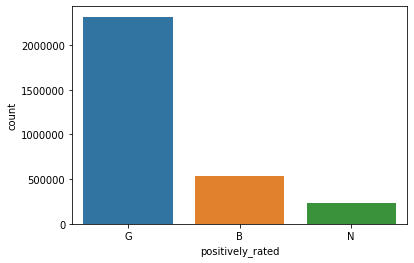

In [71]:
sns.countplot(sent_df['positively_rated'])

In [72]:
x_train, x_test, y_train, y_test = train_test_split(sent_df['review_body'], sent_df['positively_rated'], random_state = 50)

In [73]:
vect = TfidfVectorizer().fit(x_train)

In [ ]:
x_train_vectorized = vect.transform(x_train)
#model = LogisticRegression()
#model.fit(x_train_vectorized, y_train)

## PySpark

In [24]:
! pip install pyspark

In [25]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [26]:
electronics = spark.read.csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", sep = '\t')#.iloc[1:,:]
electronics.show(vertical=True)
toys = spark.read.csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Toys_v1_00.tsv.gz")

-RECORD 0--------------------
 _c0  | marketplace          
 _c1  | customer_id          
 _c2  | review_id            
 _c3  | product_id           
 _c4  | product_parent       
 _c5  | product_title        
 _c6  | product_category     
 _c7  | star_rating          
 _c8  | helpful_votes        
 _c9  | total_votes          
 _c10 | vine                 
 _c11 | verified_purchase    
 _c12 | review_headline      
 _c13 | review_body          
 _c14 | review_date          
-RECORD 1--------------------
 _c0  | US                   
 _c1  | 41409413             
 _c2  | R2MTG1GCZLR2DK       
 _c3  | B00428R89M           
 _c4  | 112201306            
 _c5  | yoomall 5M Antenn... 
 _c6  | Electronics          
 _c7  | 5                    
 _c8  | 0                    
 _c9  | 0                    
 _c10 | N                    
 _c11 | Y                    
 _c12 | Five Stars           
 _c13 | As described.        
 _c14 | 2015-08-31           
-RECORD 2--------------------
 _c0  | US

In [27]:
electronics.filter(electronics.marketplace.isNotNull()).show()

AttributeError: 'DataFrame' object has no attribute 'marketplace'

## Dask

In [ ]:
import dask as d
import dask.dataframe as dd
import dask.array as da

In [ ]:
electronics_dask = dd.read_csv("C:/Users/19495/ProjectFiles/amazon_reviews_us_Electronics_v1_00.tsv.gz", sep ='\t')